In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

This is the process, which converts the model weights during the training into 16FP and 32FP, while loading and saving the weights. This allow for better utilization of the GPU memory.

In [2]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1' # This will allow automatic expression to take place.

## Data Information
copying data into working directory.

In [3]:
import os
import shutil

# Define the source directory (current location of the images)
source_dir = '/kaggle/input/fungi-bacteria-dataset/Dataset/'

# Define the target directory (your working directory)
target_dir = '/kaggle/working/'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
file_list = os.listdir(source_dir)
print(file_list)

# Move or copy the files to the target directory
for filename in file_list:
    source_file = os.path.join(source_dir, filename)
    target_file = os.path.join(target_dir, filename)
    
    # You can either move the files (cut) or copy them (copy)
    # shutil.move(source_file, target_file)  # Move the files
    shutil.copytree(source_file, target_file)  # Copy the files

# Now, your training images should be in the working directory (target_dir).


['Validation', 'Train']


In [4]:
#  Specify root path
root_path = '/kaggle/input/fungi-bacteria-dataset/Dataset/Train/'

# Get class names
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Calculate class distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

Number of Classes : 4
Class names : ['Aspergillus', 'Penicillium', 'Proteus', 'Staphylococcus']


In [5]:
working_dir = '/kaggle/working/'
train_dir = os.path.join(working_dir, 'Train')
validation_dir = os.path.join(working_dir, 'Valiidation')

#directory with training Aspergillus images
train_aspergillus_dir = os.path.join(train_dir, 'Aspergillus')

#directory with training Penicillium images
train_penicillium_dir = os.path.join(train_dir, 'Penicillium')

#directory with training Proteus images
train_proteus_dir = os.path.join(train_dir, 'Proteus')

#directory with training Staphylococcus images
train_staphylococcus_dir = os.path.join(train_dir, 'Staphylococcus')



#directory with validation Aspergillus images
validation_aspergillus_dir = os.path.join(validation_dir, 'Aspergillus')

#directory with validation Penicillium images
validation_penicillium_dir = os.path.join(validation_dir, 'Penicillium')

#directory with validation Proteus images
validation_proteus_dir = os.path.join(validation_dir, 'Proteus')

#directory with validation Staphylococcus images
validation_staphylococcus_dir = os.path.join(validation_dir, 'Staphylococcus')

## Plotting the images from the original dataset


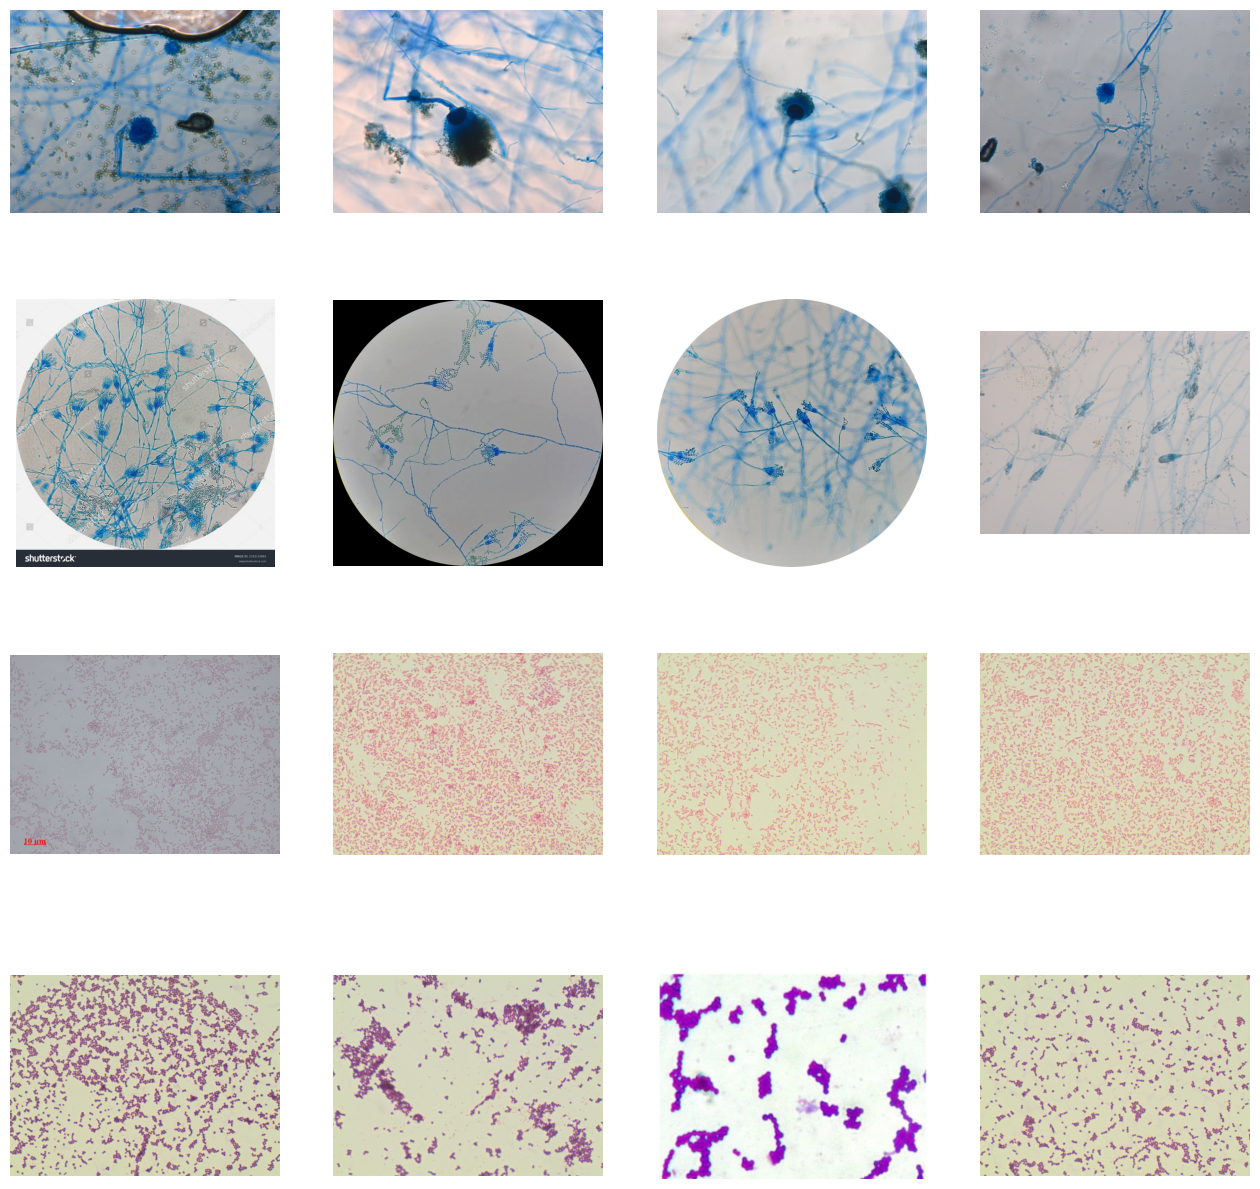

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.pyplot as plt
from PIL import Image
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 10

train_aspergillus_fnames = os.listdir( train_aspergillus_dir )
train_penicillium_fnames = os.listdir( train_penicillium_dir )
train_proteus_fnames = os.listdir( train_proteus_dir )
train_staphylococcus_fnames = os.listdir( train_staphylococcus_dir )

num_images_per_category = min(len(train_aspergillus_fnames), len(train_penicillium_fnames), len(train_proteus_fnames), len(train_staphylococcus_fnames))


next_aspergillus_pix = [os.path.join(train_aspergillus_dir, fname) 
                for fname in train_aspergillus_fnames[ pic_index-4:pic_index] 
               ][:num_images_per_category]
next_penicillium_pix = [os.path.join(train_penicillium_dir, fname) 
                for fname in train_penicillium_fnames[ pic_index-4:pic_index] 
               ][:num_images_per_category]
next_proteus_pix = [os.path.join(train_proteus_dir, fname) 
                for fname in train_proteus_fnames[ pic_index-4:pic_index] 
               ][:num_images_per_category]
next_staphylococcus_pix = [os.path.join(train_staphylococcus_dir, fname) 
                for fname in train_staphylococcus_fnames[ pic_index-4:pic_index]
               ][:num_images_per_category]

for i, img_path in enumerate(next_aspergillus_pix + next_penicillium_pix + next_proteus_pix + next_staphylococcus_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Don't show axes (or gridlines)

    img = Image.open(img_path)
    plt.imshow(img)

plt.show()

In [7]:
# Pie plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [8]:
# Bar Plot
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

## Data Augmentation
To augment the training dataset to make it more balanced, we can use various data augmentation techniques, such as rotation, flipping, and zooming, to create additional variations of your existing images. We have used Python library ImageDataGenerator from Keras to perform data augmentation on the dataset:

In [7]:
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
base_dir = '/kaggle/working/'
train_dir = os.path.join(base_dir, 'Train')
working_dir = '/kaggle/working/Train/'
validation_dir = os.path.join(base_dir, 'Validation')  


# Directory paths for each class
train_aspergillus_dir = os.path.join(train_dir, 'Aspergillus')
train_penicillium_dir = os.path.join(train_dir, 'Penicillium')
train_proteus_dir = os.path.join(train_dir, 'Proteus')
train_staphylococcus_dir = os.path.join(train_dir, 'Staphylococcus')

# Create an ImageDataGenerator with augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     #shear_range=0.2,
#     zoom_range=0.2,
#     #fill_mode='nearest'
)

# Define the number of augmented images you want per original image
augmentation_factor = 3  # You can adjust this as needed

def load_and_preprocess_image(img_path, target_size=(500, 500)):
    img = Image.open(img_path)
    
    # Convert the image to RGB mode if it's not already
    if img.mode != "RGB":
        img = img.convert("RGB")
        
    img = img.resize(target_size)
    img = np.array(img) / 255.0  # Normalize pixel values to be between 0 and 1
    return img

# Generate augmented images for each class and save them to the same directory
for class_dir in [train_aspergillus_dir, train_penicillium_dir, train_proteus_dir, train_staphylococcus_dir]:
    class_name = os.path.basename(class_dir)
    filenames = os.listdir(class_dir)
    
    
    # Create a directory for augmented images if it doesn't exist
    augmented_dir = os.path.join(working_dir, class_name)
    os.makedirs(augmented_dir, exist_ok=True)
    
    for filename in filenames:
        img_path = os.path.join(class_dir, filename)
        img = load_and_preprocess_image(img_path)  # Implement a function to load and preprocess your images
        
        # Reshape the image to (1, height, width, channels) for data augmentation
        img = img.reshape((1,) + img.shape)
        
        # Generate augmented images and save them
        i = 0
        for batch in train_datagen.flow(img, save_to_dir=augmented_dir, save_prefix=f'aug_{class_name}', save_format='jpeg'):
            i += 1
            if i >= augmentation_factor:
                break

# Now, your augmented images are saved in separate directories with appropriate class labels.

UnidentifiedImageError: cannot identify image file '/kaggle/working/Train/Staphylococcus/staphylococcus-aureus-bacteria-colonie-gram-stain-microscopic-100x-image_581734-78.avif'

In [10]:
validation_datagen = ImageDataGenerator() 


### Training and Validation Generators

In [11]:
# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=30,
    shuffle=True,
    class_mode='binary',
    target_size=(256, 256)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    shuffle=True,
    class_mode='binary',
    target_size=(256, 256)
)

Found 1479 images belonging to 4 classes.
Found 109 images belonging to 4 classes.


### Plotting the augmented dataset

In [13]:
#  Specify root path
root_path = '/kaggle/working/Train/'

# Get class names
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Calculate class distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Bar Plot
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

## Data Visulization
For better understanding the actual image classification problem, we need to have a look at the images. For this, we will create a function that will also help us at the inference time.

In [14]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):
    
    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)
    
    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size
    
    # Iterate through the subplots.
    for i in range(1, n_images+1):
        
        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]
        
        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"
        
        plt.title(title)
    plt.show()

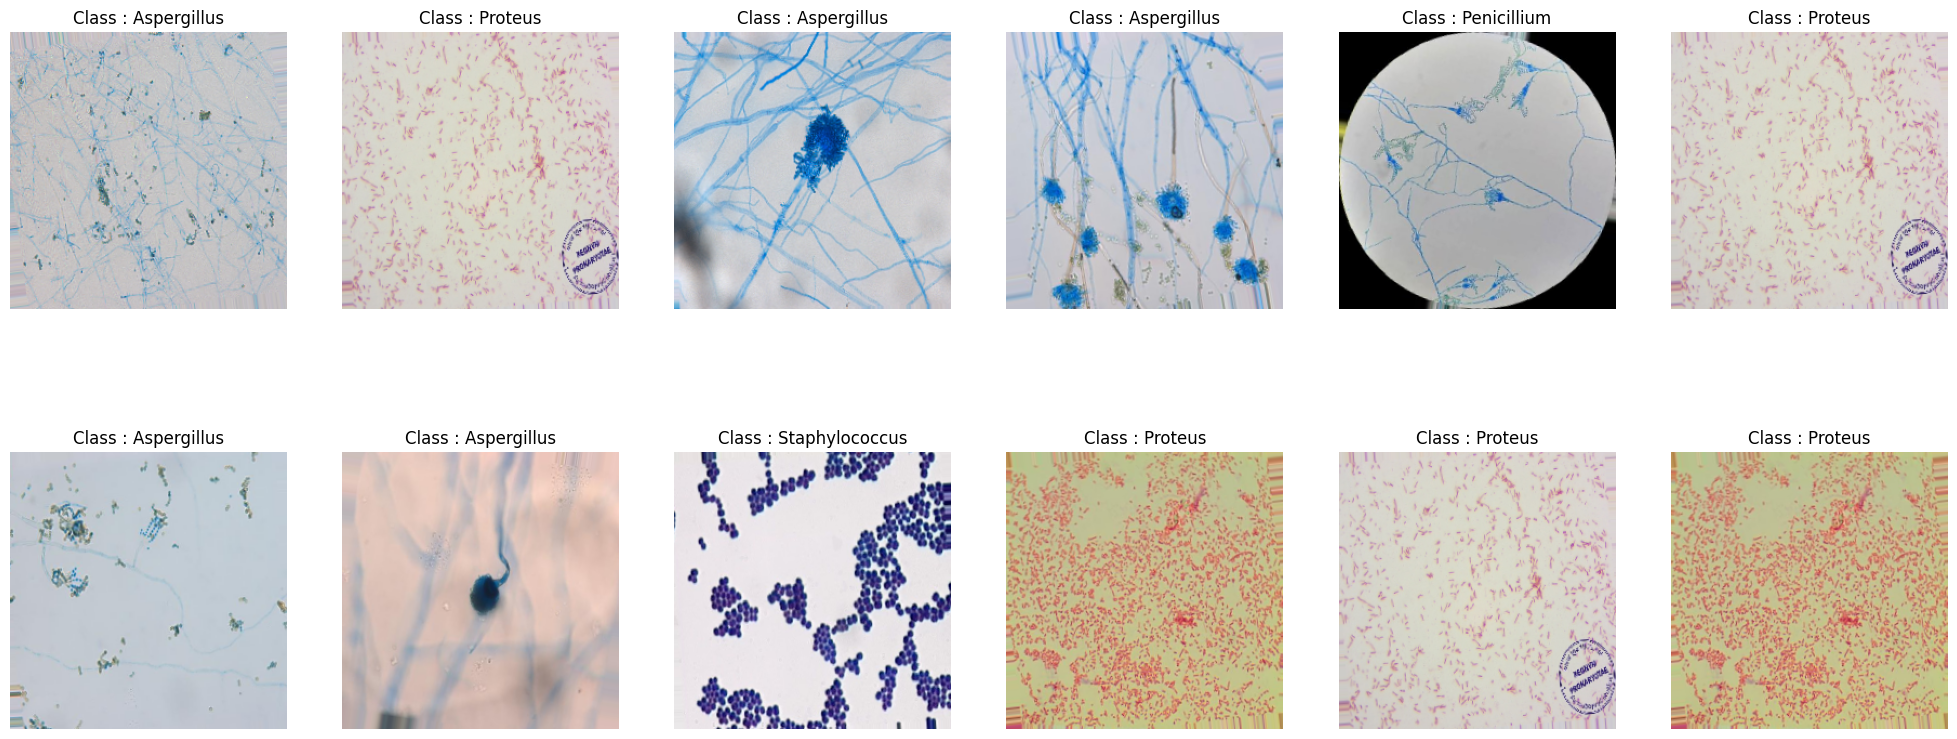

In [17]:
show_images(data=train_generator)


Loading the Base Model